In [1]:
import numpy as np
import matplotlib.pyplot as plt

from vmls import cls_solve
from dataset import portfolio_data, lq_estimation_data

# 17.1 Portfolio optimization

The goal is to make investments so that the combined return on all our investments is consistently high.

## Portfolio allocation weights

- we invest a total of $V$ dollars in $n$ different assets (stocks, bonds, ...) over some period (one day, week, month, ...)
- The allocation across the $n$ assets is described by an portfolio allocation weight n-vector $w$, which satisfies $\mathbf{1}^T w = 1$, i.e., its entries sum to one.
- can include short positions, assets you borrow and sell at the beginning, but must return to the borrower at the end of the period
- $Vw_j$ is the dollar value of asset j you hold
- $\mathbf{1}^T w = 1$, with negative $w_i$ meaning a short position
- $w$ = (−0.2, 0.0, 1.2) means we take a short position of 0.2$V$ in asset 1, don't hold any of asset 2, and hold 1.2$V$ in asset 3

- The entries of $w$ are called by various names including *fractional allocations*, *asset weights*, *asset allocations*, or just *weights*

## Leverage, long-only portfolios, and cash

- leverage is $L = |w_1| + \cdots + |w_n|$ ($(L − 1)/2$ is also sometimes used)
- $L = 1$ when all weights are nonnegative ('long only portfolio')
- $w = 1/n$ is called the uniform portfolio


- we often assume asset n is 'risk-free' (or cash or T-bills)
- so $w = e_n$ means the portfolio is all cash

## Return over a period

- $\tilde{r}_j$ is the *return* of asset j over the period
- $\tilde{r}_j$ is the fractional increase in price or value (decrease if negative), often expressed as a percentage, like +1.1% or −2.3%
- full portfolio return is
$$
\frac{V^{+} − V}{V} = \tilde{r}^T w
$$
where $V^+$ is the portfolio value at the end of the period
- if you hold portfolio for $t$ periods with returns $r_1, \ldots ,r_t$ value is
$$
V_{t+1} = V_1(1 + r_1)(1 + r_2) \cdots (1 + r_t)
$$

- portfolio value versus time traditionally plotted using $V_1$ = $10000

## Return matrix

- hold portfolio with weights $w$ over T periods
- define T × n (asset) return matrix, with $R_{tj}$ the return of asset j in period t
- row t of $R$ is $\tilde{r}^T_t$, where $\tilde{r}_t$ is the asset return vector over period t
- column j of $R$ is time series of asset j returns
- portfolio returns vector (time series) is T-vector $r = Rw$
- if last asset is *risk-free*, the last column of $R$ is $\mu^{rf} \mathbf{1}$, where $\mu^{rf}$ is the risk-free per-period interest rate

## Portfolio return and risk

- $r$ is time series (vector) of portfolio returns
- *average return* or just *return* is $\mathbf{avg}(r)$
- *risk* is $\mathbf{std}(r)$
- these are the per-period return and risk
- for **small** per-period returns we have
$$
\begin{align}
V_{T+1} &= V_1(1 + r_1) \cdots (1 + r_T) \\
&\approx V_1 + V1(r_1 + \cdots + r_T) \\
&= V_1 + T \mathbf{avg}(r)V_1
\end{align}
$$
- so return approximates the average per-period increase in portfolio value

- mean return and risk are often expressed in *annualized* form (i.e., per year)
- if there are P trading periods per year \
annualized return = $P \ \mathbf{avg}(r)$ \
annualized risk = $ \sqrt{P} \ \mathbf{std}(r)$ \
(the squareroot in risk annualization comes from the assumption that the fluctuations in return around the mean are independent)

## Compounded portfolio value
$$v_t = 10000(1 + r_1) \cdots (1 + r_{t−1}), \quad t = 1, \ldots , T$$

In [2]:
# Portfolio value with re-investment, return time series r
cum_value = lambda r: 10000 * np.cumprod(1 + r)

# Generate random returns sequence with
# 10% annualized return, 5% annualized risk
mu = 0.10 / 250
sigma = 0.05 / np.sqrt(250)
T = 250  # One year’s worth of trading days
r = mu + sigma*np.random.standard_normal(T);
v = cum_value(r);
# compare final value (compounded) and average return
v[T-1] , v[1]*(1+sum(r))

(11174.854499093743, 11149.048536496528)

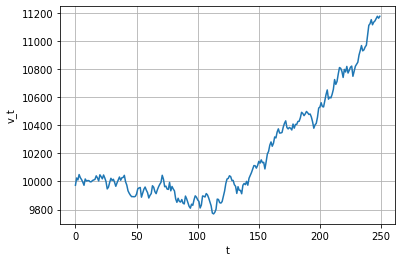

In [3]:
plt.ion()
plt.plot(np.arange(T), v)
plt.grid()
plt.xlabel('t')
plt.ylabel('v_t')
plt.show()

## Portfolio optimization

- choose the portfolio weight vector $w$ to achieve high (mean) portfolio return, low portfolio risk
- we know **past realized asset returns** but not future ones, so we make a big assumption (BA)\
    **future returns will look something like past ones**
    - you are warned this is false, every time you invest
    - it is often reasonably true
    - in periods of 'market shift' it's much less true
- if BA holds (even approximately), then a good weight vector for past (realized) returns should be good for future (unknown) returns (just like data fitting)

- fix the return of the portfolio to be some given value $\rho$, and minimize the risk over all portfolios that achieve the required return
-  Requiring that the portfolio return be $\rho$ can be expressed as
$$
\mathbf{avg}(r) = (1/T)\mathbf{1}^T (Rw) = \mu^T w = \rho,
$$
where $\mu = R^T \mathbf{1}/T$ is the n-vector of the average asset returns.
- the square of the risk can be expressed as
$$
\mathbf{std}(r)^2 = (1/T)\|r − \mathbf{avg}(r)\mathbf{1}\|^2 = (1/T)\|r − \rho\mathbf{1}\|^2
$$
- portfolio optimization can be expressed as
$$
\begin{align}
\text{minimize} & & \mathbf{std}(Rw)^2 = (1/T)\|Rw − \rho\mathbf{1}\|^2 \\
\text{subject to} & & \begin{aligned} \mathbf{1}^T w = 1 \\ \mathbf{avg}(Rw) = \rho \end{aligned}
\end{align}
$$

- portfolio optimization via constrained least squares
$$
\begin{align}
\text{minimize} & & \|Rw − \rho\mathbf{1}\|^2 \\
\text{subject to} & & \begin{bmatrix} \mathbf{1}^T \\ \mu^T \end{bmatrix} w = \begin{bmatrix} 1 \\ \rho \end{bmatrix}
\end{align}
$$
- an equality constrained least squares problem, with solution
$$
\begin{bmatrix}
w \\ z_1 \\ z_2
\end{bmatrix}
=
\begin{bmatrix}
2R^T R & \mathbf{1} & \mu \\
\mathbf{1}^T & 0 & 0 \\
\mu^T & 0 & 0
\end{bmatrix}^{-1}\
\begin{bmatrix}
2 R^T \rho\mathbf{1}\\
1 \\
\rho
\end{bmatrix}
=
\begin{bmatrix}
2R^T R & \mathbf{1} & \mu \\
\mathbf{1}^T & 0 & 0 \\
\mu^T & 0 & 0
\end{bmatrix}^{-1}\
\begin{bmatrix}
2 \rho T \mu\\
1 \\
\rho
\end{bmatrix}
$$

---
**Optimal portfolios**
- risk-return curve forms a straight line
- one end of the line is the risk-free asset
- two-fund theorem: optimal portfolio $w$ is an affine function of $\rho$
$$
\begin{bmatrix}
w \\ z_1 \\ z_2
\end{bmatrix}
=
\begin{bmatrix}
2R^T R & \mathbf{1} & \mu \\
\mathbf{1}^T & 0 & 0 \\
\mu^T & 0 & 0
\end{bmatrix}^{-1}\
\begin{bmatrix}
0\\
1 \\
0
\end{bmatrix}
+
\rho
\begin{bmatrix}
2R^T R & \mathbf{1} & \mu \\
\mathbf{1}^T & 0 & 0 \\
\mu^T & 0 & 0
\end{bmatrix}^{-1}\
\begin{bmatrix}
2 T \mu\\
0 \\
1
\end{bmatrix}
$$

In [4]:
def port_opt(R, rho):
    """portfolio optimization"""
    T, n = R.shape
    mu = np.sum(R, axis = 0).T / T
    KKT = np.vstack([np.column_stack([2*R.T @ R, np.ones(n), mu]),
                     np.hstack([np.ones(n).T, 0 , 0]),
                     np.hstack([mu.T, 0, 0])])
    wz1z2 = np.linalg.lstsq(KKT, np.hstack([2*rho*T*mu, 1, rho]), rcond=None)[0]
    w = wz1z2[:n]
    return w

R, Rtest = portfolio_data()
T, n = R.shape
rho = 0.1/250  # Ask for 10% annual return
w = port_opt(R, rho)
r = R @ w  # Portfolio return time series
pf_return = 250 * sum(r)/len(r)
pf_risk = np.sqrt(250) * np.std(r)
print(pf_return)
print(pf_risk)

0.10000000000000368
0.08650183078056148


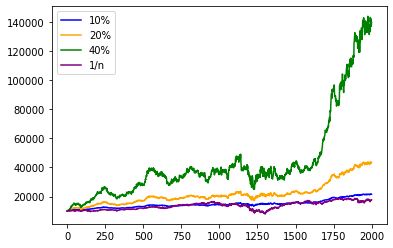

In [5]:
cum_value = lambda r: 10000*np.cumprod(1+r)

# 10% annual return
rho = 0.1 / 250 # Ask for 10% annual return
w = port_opt(R, rho)
r = R @ w  # Portfolio return time series
plt.plot(np.arange(T), cum_value(r), 'blue')

# 20% annual return
rho = 0.2 / 250
w = port_opt(R, rho)
r = R @ w  # Portfolio return time series
plt.plot(np.arange(T), cum_value(r), 'orange')

# 40% annual return
rho = 0.4 / 250
w = port_opt(R, rho)
r = R @ w  # Portfolio return time series
plt.plot(np.arange(T), cum_value(r), 'green')

# Uniform portolio
w = (1/n) * np.ones(n)
r = R @ w  # Portfolio return time series
plt.plot(np.arange(T), cum_value(r), 'purple')
plt.legend(['10%','20%','40%','1/n'])
plt.show()

# 17.2 Linear quadratic control

## time-varying linear dynamical system

**dynamic equation and system outputs**
$$
\begin{align}
x_{t+1} &= A_tx_t + B_tu_t, \quad t = 1, 2, \ldots \\
y_{t} &= C_t x_t, \quad t = 1, 2, \ldots
\end{align}
$$
- n-vector $x_t$ is state at time $t$
- m-vector $u_t$ is input at time $t$
- p-vector $y_t$ is output at time $t$
- n × n matrix $A_t$ is dynamics matrix
- n × m matrix $B_t$ is input matrix
- p × n matrix $C_t$ is output matrix
- $x_t, u_t, y_t$ often represent deviations from a standard operating condition. For this reason it is desirable to have $x_t, u_t, y_t$ small.

## Linear quadratic control

*Linear quadratic control* refers to the problem of choosing the **input** and **state** sequences, over a time period $t = 1, \ldots , T$, so as to **minimize** a sum of squares objective, subject to the **dynamics equations**, the **output equations**, and **additional linear equality constraints**.

$$
\begin{align}
\text{minimize} & \quad J_{output} + \rho J_{input}\\
\text{subject to} & \quad
    \begin{aligned}
        &x_{t+1} = A_t x_t + B_t u_t, \quad t = 1, \ldots, T-1 \\
        &x_1 = x^{init}, \ x_T = x^{des}
    \end{aligned}
\end{align} \\
$$

- variables are state sequence  $x_1, \ldots, x_T$ and  input sequence $u_1, \ldots, u_{T−1}$
- two objectives are quadratic functions of state and input sequences:
$$
J_{output} = \|y_1\|^2 + \cdots + \|y_T|^2 = \|C_1 x_1|^2 + \cdots + \|C_T x_T|^2 \\
J_{input} = \|u_1\|^2 + \cdots + \|u_T|^2
$$
- first constraint imposes the linear dynamics equations
- second set of constraints specifies the initial and final state

## Constrained least squares formulation

- concatenate vector $x$ and $u$, we get the vector z containing the Tn + (T − 1)m variables:
$$ z = (x_1, \ldots, x_T, u_1, \ldots, u_{T-1})$$

- rewrite optimization formula
$$
\begin{align}
\text{minimize} & &\ \|\tilde{A}z - \tilde{b}\|^2\\
\text{subject to} & &\ \tilde{C}z = \tilde{d}
\end{align} \\
$$

  where
$$
\tilde{A} = \begin{bmatrix}
C_1 & \cdots & 0 & 0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & C_T & 0 & \cdots & 0 \\
0 & \cdots & 0 & \sqrt{\rho}I & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & 0 & 0 & \cdots & \sqrt{\rho}I
\end{bmatrix}
$$

$$
\tilde{b} = 0
$$

$$
\tilde{C} = \begin{bmatrix}
A_1 & -I & 0 & \cdots & 0 & 0 & B_1 & 0 & \cdots & 0 \\
0 & A_2 & -I & \cdots & 0 & 0 & 0 & B_2 & \cdots & 0 \\
\vdots & \vdots & \vdots &  & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & A_{T-1} & -I & 0 & 0 & \cdots & B_{T-1} \\
I & 0 & 0 & \cdots & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & \cdots & 0 & I & 0 & 0 & \cdots & 0
\end{bmatrix}
$$

$$
\tilde{d} = \begin{bmatrix}
0 \\
0 \\
\vdots \\
0 \\
x_{init} \\
x_{des}
\end{bmatrix}
$$

**Kronecker product.** To create the big matrices $\tilde{A}$ and \tilde{C}, we need to define block diagonal matrices with the same matrix repeated a number of times along the diagonal. There are many ways to do this in Python. One of the simplest ways uses the `np.kron` function, for the Kronecker product of two matrices. The Kronecker product of an `m × n`
matrix $G$ and a `p × q` matrix $H$ is defined as the `mp × nq` block matrix
$$
\begin{bmatrix}
G_{11}H & G_{12}H & \ldots & G_{1n}G \\
G_{21}H & G_{22}H & \ldots & G_{2n}G \\
\vdots & \vdots &  & \vdots \\
G_{m1}H & G_{m2}H & \ldots & G_{mn}G
\end{bmatrix}
$$
It is computed in Python as `np.kron(G,H)`. If $G$ is an `n × n` identity matrix, we obtain the block diagonal matrix with $H$ repeated n times on the diagonal.

In [6]:
H = np.random.normal(size=(2, 2))
print(np.kron(np.eye(3), H))

[[ 0.61481591  1.08556363  0.          0.          0.          0.        ]
 [-1.57274693 -1.89655522 -0.         -0.         -0.         -0.        ]
 [ 0.          0.          0.61481591  1.08556363  0.          0.        ]
 [-0.         -0.         -1.57274693 -1.89655522 -0.         -0.        ]
 [ 0.          0.          0.          0.          0.61481591  1.08556363]
 [-0.         -0.         -0.         -0.         -1.57274693 -1.89655522]]


In [7]:
G = np.eye(3)
H = np.random.normal(size=(2, 2))

m, n = G.shape
p, q = H.shape

print(np.kron(G, H))
print((G[:, None, :, None] * H[None, :, None, :]).reshape(m*p, n*q))  # broadcasting 
print(np.einsum('ik,jl', G, H).reshape(m*p, n*q))

[[-0.64290848 -1.13654828 -0.         -0.         -0.         -0.        ]
 [ 0.60017488 -1.43839214  0.         -0.          0.         -0.        ]
 [-0.         -0.         -0.64290848 -1.13654828 -0.         -0.        ]
 [ 0.         -0.          0.60017488 -1.43839214  0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.64290848 -1.13654828]
 [ 0.         -0.          0.         -0.          0.60017488 -1.43839214]]
[[-0.64290848 -1.13654828 -0.         -0.         -0.         -0.        ]
 [ 0.60017488 -1.43839214  0.         -0.          0.         -0.        ]
 [-0.         -0.         -0.64290848 -1.13654828 -0.         -0.        ]
 [ 0.         -0.          0.60017488 -1.43839214  0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.64290848 -1.13654828]
 [ 0.         -0.          0.         -0.          0.60017488 -1.43839214]]
[[-0.64290848 -1.13654828  0.          0.          0.          0.        ]
 [ 0.60017488 -1.438392

**Linear quadratic control example.** We start by writing a function `lqr` that constructs and solves the constrained least squares problem for linear quadratic control.
The function returns three arrays

> x = [ x[1], x[2], ..., x[T] ], \
> u = [ u[1], u[2], ..., u[T-1] ], \
> y = [ y[1], y[2], ..., y[T] ].

The first two contain the optimal solution of the problem. The third array contains $y_t = Cx_t$.
We allow the input arguments **x_init** and **x_des** to be matrices, so we can solve the same problem for different pairs of initial and end states, with one function call. If the number of columns in **x_init** and **x_des** is q, then the entries of the three output sequences **x**, **u**, **y** are matrices with q columns. The ith columns are the
solution for the initial and end states specified in the ith columns of **x_init** and **x_des**.

In [8]:
def lqr(A, B, C, x_init, x_des, T, rho):
    """Linear quadratic control"""
    n = A.shape[0]
    m = B.shape[1]
    p = C.shape[0]
    q = x_init.shape[1]
    
    Atil = np.vstack([np.hstack([np.kron(np.eye(T), C), np.zeros((p*T, m*(T-1)))]),
                      np.hstack([np.zeros((m*(T-1), n*T)), np.sqrt(rho)*np.eye(m*(T-1))])])
    
    btil = np.zeros((p*T+m*(T-1), q))
    
    # We'll construct Ctilde bit by bit
    Ctil11 = np.hstack([np.kron(np.eye(T-1), A), np.zeros((n*(T-1), n))]) \
             - np.hstack([np.zeros((n*(T-1), n)), np.eye(n*(T-1))])
    Ctil12 = np.kron(np.eye(T-1), B)
    Ctil21 = np.vstack([np.hstack([np.eye(n), np.zeros((n, n*(T-1)))]),
                        np.hstack([np.zeros((n, n*(T-1))), np.eye(n)])])
    Ctil22 = np.zeros((2*n, m*(T-1)))
    Ctil = np.block([[Ctil11, Ctil12],
                     [Ctil21, Ctil22]])
    
    dtil = np.vstack([np.zeros((n*(T-1), q)),
                      x_init,
                      x_des])
    
    z = cls_solve(Atil, btil, Ctil, dtil)
    
    x = [z[i*n:(i+1)*n, :] for i in range(T)]  # list of np.ndarray
    u = [z[n*T+i*m:n*T+(i+1)*m, :] for i in range(T-1)]  # list of np.ndarray
    y = [C @ xt for xt in x]  # list of np.ndarray
    return x, u, y

In [9]:
A = np.array([[ 0.855, 1.161, 0.667],
              [0.015, 1.073, 0.053],
              [-0.084, 0.059, 1.022 ]])
B = np.array([[-0.076], [-0.139] ,[0.342 ]])
C = np.array([[ 0.218, -3.597, -1.683 ]])
n = 3
p = 1
m = 1
x_init = np.array([[0.496], [-0.745], [1.394]])
x_des = np.zeros((n,1))

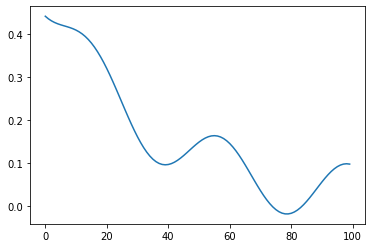

In [10]:
# open-loop response
T = 100
yol = np.zeros((T, 1))
Xol = np.hstack([x_init, np.zeros((n, T-1))])
for k in range(T-1):
    Xol[:, k+1] = A @ Xol[:, k]
yol = C @ Xol
plt.plot(np.arange(T), yol.T)
plt.show()

In [11]:
# solve the linear quadratic control problem with T = 100 and rho = 0.2
rho = 0.2
T = 100
x, u, y = lqr(A, B, C, x_init, x_des, T, rho)
J_input = np.linalg.norm(u)**2
J_output = np.linalg.norm(y)**2
print(J_input)
print(J_output)

0.7738942551160511
3.7829986463324397


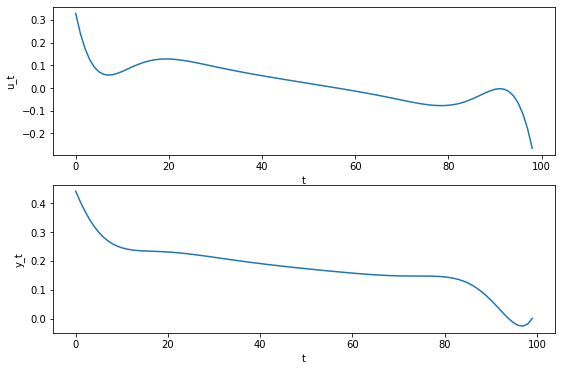

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(np.arange(T-1), np.vstack(u))
ax[0].set_xlabel('t')
ax[0].set_ylabel('u_t')

ax[1].plot(np.arange(T), np.vstack(y))
ax[1].set_xlabel('t')
ax[1].set_ylabel('y_t')
plt.show()

## Linear state feedback control

- In *linear state feedback control* we measure the state in each period and use the input
$$
u_t = K x_t, \quad t = 1, 2, \cdots
$$
- matrix $K$ is called the *state feedback gain matrix*
- widely used, especially when $x_t$ should converge to zero, $T$ is not specified


- one choice for $K$: solve linear quadratic control problem with $x^{des} = 0$
- The solution $\hat{z}$ is a linear function of $x^{init}$ and $x^{des}$; since here $x^{des} = 0$, $\hat{z}$ is a linear function of $x^{init} = x_1$
- Since $\hat{u}_1$, the optimal input at t = 1, is a slice or subvector of $\hat{z}$, we conclude that $\hat{u}_1$ is a linear function of $x_1$, and so can be written as 
     $$u_1 = K x_1$$
- columns of $K$ can be found by computing $u_1$ for $x^{init} = e_1, \ldots, e_n$
- use this $K$ as state feedback gain matrix

In [13]:
# Solve LQ problem with x_init = I, x_des = 0
rho = 1.0
n = 3
xsf, usf, ysf = lqr(A, B, C, np.eye(n), np.zeros((n, n)), T, rho)
K = usf[0]
print(K)

# Simulate over horizon 150
TT = 150
Xsf = np.hstack([x_init, np.zeros((n, TT-1))])
for k in range(TT - 1):
    Xsf[:, k+1] = (A+B*K) @ Xsf[:, k]
usf = K @ Xsf[:, 0:TT-1]
ysf = C @ Xsf

# Also compute optimal LQ solution for rho = 1.0
x, u, y = lqr(A, B, C, x_init, x_des, T, rho)

[[ 0.30832877 -2.65864963 -1.44602291]]


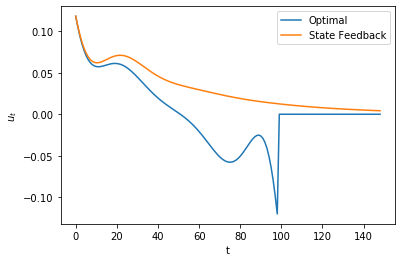

In [14]:
# Plot the two inputs
plt.plot(np.vstack([np.vstack(u), np.zeros((TT-T,1))]))
plt.plot(usf.T)
plt.legend(["Optimal", "State Feedback"])
plt.xlabel('t')
plt.ylabel('$u_t$')
plt.show()

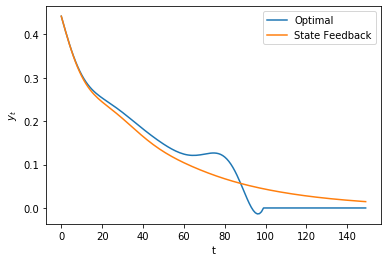

In [15]:
# Plot the two outputs
plt.plot(np.vstack([np.vstack(y), np.zeros((TT-T, 1))]))
plt.plot(ysf.T)
plt.legend(["Optimal", "State Feedback"])
plt.xlabel('t')
plt.ylabel('$y_t$')
plt.show()

# 17.3 Linear quadratic state estimation

- linear dynamical system:
$$
x_{t+1} = A_t x_t + B_t w_t, \quad y_t = C_t x_t + v_t, \quad t = 1, 2, \ldots
$$
- $x_t$ is the *state* (n-vector)
- $y_t$ is the *measurement* (p-vector)
- $w_t$ is the *input* or *process noise* (m-vector)
- $v_t$ is the *measurement noise* or *residual* (p-vector)
- $A_t$ is the dynamics matrix (n x n)
- $B_t$ is the input matrix (n x m)
- $C_t$ is the output matrix (p x n)
- we know $A_t, B_t, C_t$, and measurements $y_1, \ldots, y_T$
- $w_t, v_t$ are unknown, but assumed small
- state estimation: guess or estimate the state sequence, $x_1, \ldots, x_T$

**Key concept:** guess or estimate the state sequence $x_1, \ldots , x_T$ and process noise sequence $w_1, \ldots, w_{T-1}$, subject to the requirement that they satisfy the dynamic system model

**Assumption:** process and measurement noises are both small, or at least, not too large.

$$
\begin{align}
\text{minimize} & \quad J_{meas} + \lambda J_{proc}\\
\text{subject to} & \quad x_{t+1} = A_t x_t + B_t w_t
\end{align}
$$
- primary objective: sum of squares of the norms of the measurement residuals
$$
J_{meas} = \|C_1 x_1 - y_1\|^2 + \cdots + \|C_T x_T - y_T\|^2
$$
- secondary objective: sum of squares of the norms of the process noise
$$
J_{meas} = \|w_1\|^2 + \cdots + \|w_{T-1}\|^2
$$

- concatenate vector $x$ and $w$, we get the vector z containing the Tn + (T − 1)m variables:
$$ z = (x_1, \ldots, x_T, w_1, \ldots, w_{T-1})$$

- rewrite optimization formula
$$
\begin{align}
\text{minimize} & &\ \|\tilde{A}z - \tilde{b}\|^2\\
\text{subject to} & &\ \tilde{C}z = \tilde{d}
\end{align} \\
$$

  where
$$
\tilde{A} = \begin{bmatrix}
C_1 & \cdots & 0 & 0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & C_T & 0 & \cdots & 0 \\
0 & \cdots & 0 & \sqrt{\rho}I & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & 0 & 0 & \cdots & \sqrt{\rho}I
\end{bmatrix}
$$

$$
\tilde{b} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_T \\
0 \\
\vdots \\
0
\end{bmatrix}
$$

$$
\tilde{C} = \begin{bmatrix}
A_1 & -I & 0 & \cdots & 0 & 0 & B_1 & 0 & \cdots & 0 \\
0 & A_2 & -I & \cdots & 0 & 0 & 0 & B_2 & \cdots & 0 \\
\vdots & \vdots & \vdots &  & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & A_{T-1} & -I & 0 & 0 & \cdots & B_{T-1}
\end{bmatrix}
$$

$$
\tilde{d} = 0
$$

In [16]:
def lqe(A, B, C, y, T, lam):
    """Linear quadratic state estimation"""
    n = A.shape[0]  # shape = (n, n)
    m = B.shape[1]  # shape = (n, m)
    p = C.shape[0]  # shape = (p, n)
    
    Atil = np.block([[np.kron(np.eye(T), C), np.zeros((T*p, m*(T-1)))],
                     [np.zeros((m*(T-1), T*n)), np.sqrt(lam)*np.eye(m*(T-1))]])
    
    # We assume y is a p by T array, so we vectorize it
    btil = np.block([np.hstack([i for i in y.T]), np.zeros((m*(T-1)))])
    
    Ctil = np.block([np.block([np.kron(np.eye(T-1),A), np.zeros((n*(T-1), n))])
                     + np.block([np.zeros((n*(T-1), n)), -np.eye(n*(T-1))]), np.kron(np.eye(T-1), B)])
    
    dtil = np.zeros(n*(T-1))
    
    z = cls_solve(Atil, btil, Ctil, dtil)
    
    x = [z[i*n:(i+1)*n] for i in range(T)]  # list of np.ndarray
    u = [z[n*T+i*m : n*T+(i+1)*m] for i in range(T-1)]  # list of np.ndarray
    y = [C @ xt for xt in x]  # list of np.ndarray
    return x, u, y

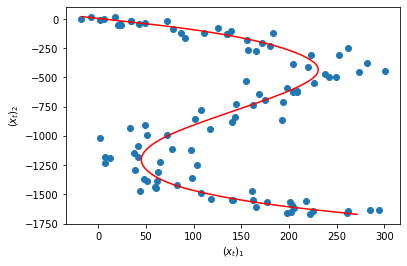

In [17]:
y_meas = lq_estimation_data()

# n = 4, m = 2, p = 2
A = np.block([[np.eye(2), np.eye(2)],
              [np.zeros((2, 2)), np.eye(2)]])
B = np.block([[np.zeros((2, 2))],
              [np.eye(2)]])
C = np.block([[np.eye(2), np.zeros((2,2))]])

T = 100
lam = 1e+3
x_hat, u_hat, y_hat = lqe(A, B, C, y_meas, T, lam)


plt.scatter(y_meas[0, :], y_meas[1, :])
plt.plot(np.array([yt[0] for yt in y_hat]),
         np.array([yt[1] for yt in y_hat]),'r')
plt.xlabel('$(x_t)_1$')
plt.ylabel('$(x_t)_2$')
plt.show()